In [6]:
import math
import keras
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

plt.style.use('default')

In [7]:
market = 'BTC-GBP'
granularity = 3600

In [8]:
def getHistoricalData(market: str='BTC-GBP', granularity: int=3600, iso8601start: str='', iso8601end: str='') -> pd.DataFrame:
  if iso8601start != '' and iso8601end == '':
    resp = requests.get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={granularity}&start={iso8601start}')
  elif iso8601start != '' and iso8601end != '':
    resp = requests.get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={granularity}&start={iso8601start}&end={iso8601end}')
  else:
    resp = requests.get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={granularity}')

  df = pd.DataFrame.from_dict(resp.json())
  df.columns = [ 'epoch','low','high','open','close','volume' ]
  df['adj_close'] = df['close']

  tsidx = pd.DatetimeIndex(pd.to_datetime(df['epoch'], unit='s'), dtype='datetime64[ns]')
  df.set_index(tsidx, inplace=True)
  df = df.drop(columns=['epoch'])
  df.index.names = ['date']

  return df.iloc[::-1].reset_index()

In [9]:
def getHistoricalDataChained(market: str='BTC-GBP', granularity: int=3600, max_interations: int=1) -> pd.DataFrame:
  df1 = getHistoricalData(market, granularity)

  if max_interations == 1:
    return df1

  def getPreviousDateRange(df: pd.DataFrame=None) -> tuple:
    end_date = df['date'].min() - timedelta(seconds=(granularity / 60))
    new_start = df['date'].min() - timedelta(hours=300)
    return (str(new_start).replace(' ', 'T'), str(end_date).replace(' ', 'T'))

  iterations = 0
  result_df = pd.DataFrame()
  while iterations < (max_interations - 1):
    start_date, end_date = getPreviousDateRange(df1)
    df2 = getHistoricalData(market, granularity, start_date, end_date)
    result_df = pd.concat([df2, df1]).drop_duplicates()
    df1 = result_df
    iterations = iterations + 1

  if 'date'in result_df:
    result_df.sort_values(by=['date'], ascending=True, inplace=True)
        
  return result_df

In [10]:
df = getHistoricalDataChained(market, granularity, 30) # 1 year
df.shape

(8998, 7)

In [11]:
print (f'{df.shape[0] / 24} days of hourly trading data!')

374.9166666666667 days of hourly trading data!


In [12]:
df.head()

,date,low,high,open,close,volume,adj_close
0,2020-06-08 16:00:00,7631.05,7681.00,7656.12,7673.23,41.489209,7673.23
1,2020-06-08 17:00:00,7655.33,7690.97,7673.22,7670.00,31.664561,7670.00
2,2020-06-08 18:00:00,7641.03,7684.35,7668.60,7644.10,30.077688,7644.10
3,2020-06-08 19:00:00,7628.01,7657.23,7643.41,7630.88,40.625751,7630.88
4,2020-06-08 20:00:00,7630.00,7660.60,7630.82,7636.61,25.051888,7636.61


In [13]:
train_size = round(len(df) * 0.7)
test_size = len(df) - train_size

training_set = df.iloc[:train_size, 4:5].values # close
test_set = df.iloc[train_size:, 4:5].values # close

training_set.shape, test_set.shape

((6299, 1), (2699, 1))

In [14]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

window = 24 # 1 day (24 hours)

X_train = []
y_train = []
for i in range(window, train_size):
    X_train.append(training_set_scaled[i-window:i,0])
    y_train.append(training_set_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_train.shape, y_train.shape

((6275, 24, 1), (6275,))

In [15]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # output layer
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
197/197 [==============================] - 21s 8ms/step - loss: 0.0155
Epoch 2/100
197/197 [==============================] - 2s 8ms/step - loss: 0.0014
Epoch 3/100
197/197 [==============================] - 2s 8ms/step - loss: 0.0011
Epoch 4/100
197/197 [==============================] - 2s 8ms/step - loss: 0.0011
Epoch 5/100
197/197 [==============================] - 2s 8ms/step - loss: 0.0013
Epoch 6/100
197/197 [==============================] - 2s 8ms/step - loss: 9.7028e-04
Epoch 7/100
197/197 [==============================] - 2s 8ms/step - loss: 9.3396e-04
Epoch 8/100
197/197 [==============================] - 2s 8ms/step - loss: 8.9371e-04
Epoch 9/100
197/197 [==============================] - 2s 8ms/step - loss: 8.2090e-04
Epoch 10/100
197/197 [==============================] - 2s 8ms/step - loss: 0.0013
Epoch 11/100
197/197 [==============================] - 2s 8ms/step - loss: 8.8694e-04
Epoch 12/100
197/197 [==============================] - 2s 8ms/step - loss:

In [16]:
dataset_train = df.iloc[:train_size, 4:5] # close
dataset_test = df.iloc[train_size:, 4:5] # close
dataset_total = pd.concat((dataset_train, dataset_test), axis=0)

inputs = dataset_total[len(dataset_total)-len(dataset_test)-window:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

X_test = []
for i in range(window, len(test_set)+window):
  X_test.append(inputs[i-window:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_test.shape)

(2699, 24, 1)


In [17]:
predicted_price = model.predict(X_test)
predicted_price = sc.inverse_transform(predicted_price)

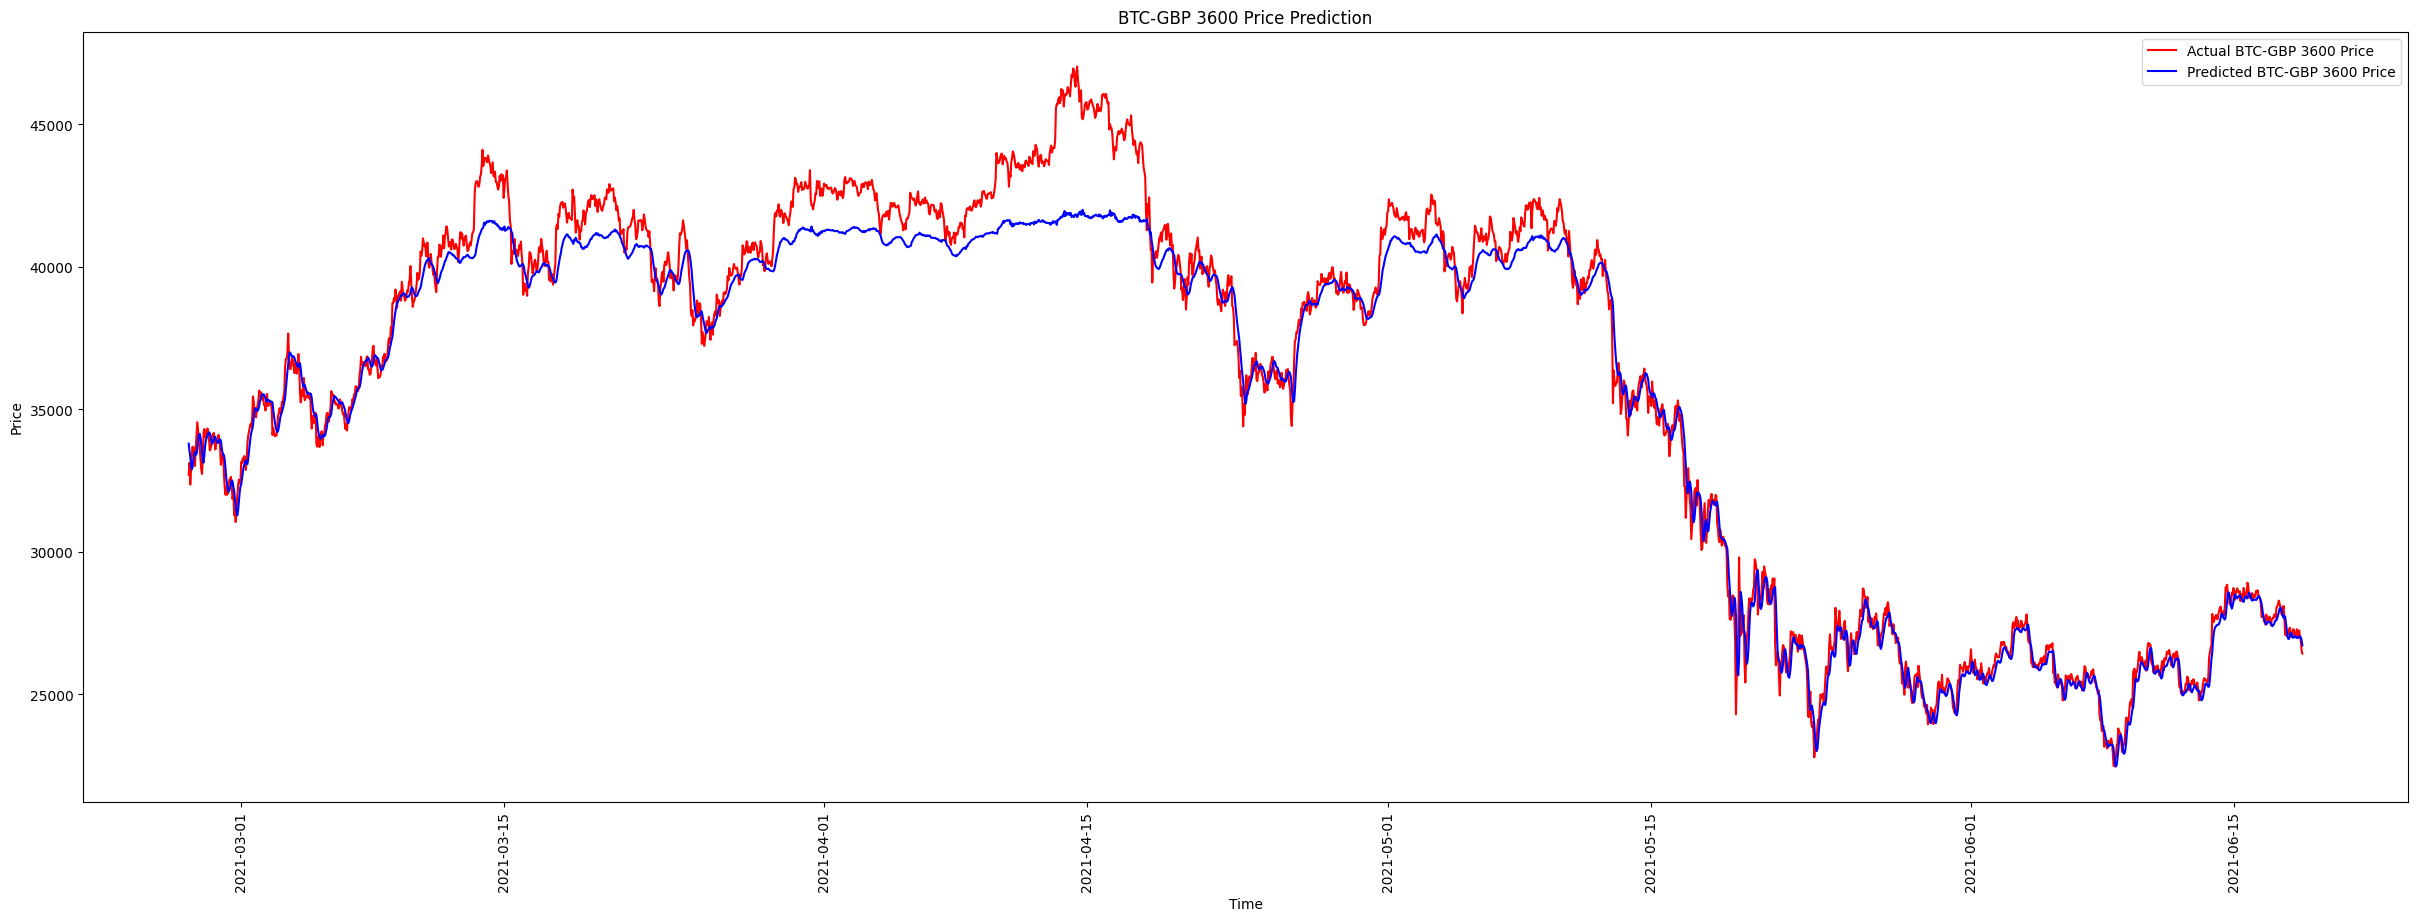

In [18]:
plt.figure(figsize=(30,10))
plt.plot(df[train_size:]['date'], dataset_test.values, color='red', label=f'Actual {market} {granularity} Price')
plt.plot(df[train_size:]['date'], predicted_price, color='blue', label=f'Predicted {market} {granularity} Price')
plt.title(f'{market} {granularity} Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'Price')
plt.xticks(rotation=90)
plt.legend()
plt.show()